In [119]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [4]:
words = open('../makemore/names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [87]:
max(len(w) for w in words)

15

In [ ]:
vocab = sorted(list(set(''.join(words))))

stoi = {ch:i+1 for i,ch in enumerate(vocab)}
stoi['.'] = 0

itos = {i:ch for ch,i in stoi.items()}
vocab_size = len(itos)

27

In [1034]:
batch_size = 64
n_embd = 128
hidden_dim = 128

In [1035]:
n = int(len(words) * 0.9)
train_words = words[:n]
val_words = words[n:]

In [1036]:

def get_batch(split, bs = batch_size):
    inp_seq, out_seq = [], [] # list of sequence of chars in input and output (shifted by 1)
    data = train_words if split == 'train' else val_words
    ix = torch.randint(len(data)-1, (batch_size,))
    batch = [data[i] for i in ix]
    for word in batch:
        chs = word + '.'
        inp, out = [], []
        inp = [stoi[ch1] for ch1,_ in zip(chs, chs[1:])]
        out = [stoi[ch2] for _,ch2 in zip(chs, chs[1:])]

        inp_seq.append(torch.tensor(inp))
        out_seq.append(torch.tensor(out))
    inp_seq_padded = pad_sequence(inp_seq, batch_first=True, padding_value=0)
    out_seq_padded = pad_sequence(out_seq, batch_first=True, padding_value=-1)
    return inp_seq_padded, out_seq_padded

In [1038]:
xb, yb = get_batch('train')
type(xb), type(yb)
# get_batch('train')

(torch.Tensor, torch.Tensor)

In [1039]:
xb.shape, yb.shape

(torch.Size([64, 11]), torch.Size([64, 11]))

In [1040]:
emb_layer = torch.randn((vocab_size, n_embd)) # (27, n_embd)

x_emb = emb_layer[xb]
x_emb.shape

torch.Size([64, 11, 128])

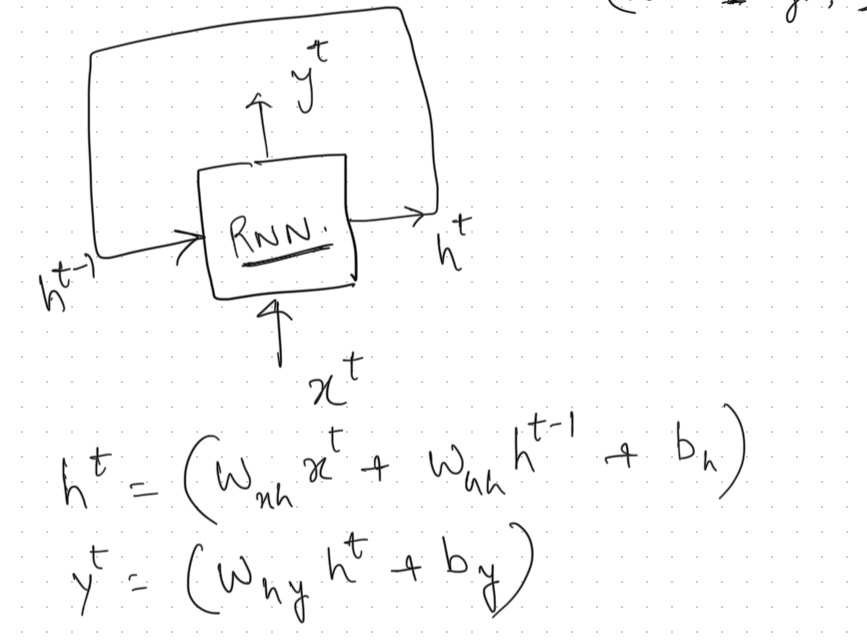

In [1297]:
# class RNN:

#     def __init__(self, n_embd, hidden_dim, vocab_size=vocab_size):
#         # self.n_embd = n_embd
#         # self.hidden_dim = hidden_dim
#         self.wxh = torch.randn(n_embd, hidden_dim) # (b,t,n_embd) -> (b,t,hidden_dim)
#         self.whh = torch.randn(hidden_dim, hidden_dim) # (b,t,hidden_dim) -> (b,t,hidden_dim)
#         self.bh  = torch.zeros(hidden_dim)

#         self.why = torch.randn(hidden_dim, vocab_size) # (b,t,hidden_dim) -> (b,t,vocab_size)
#         self.by  = torch.zeros(vocab_size)

wxh = torch.randn(n_embd, hidden_dim) * 0.01 # (b,t,n_embd) -> (b,t,hidden_dim)
whh = torch.randn(hidden_dim, hidden_dim) * 0.01 # (b,t,hidden_dim) -> (b,t,hidden_dim)
bh  = torch.zeros(hidden_dim)

why = torch.randn(hidden_dim, vocab_size) * 0.01 # (b,t,hidden_dim) -> (b,t,vocab_size)
by  = torch.zeros(vocab_size)

parameters = [emb_layer, wxh, whh, bh, why, by]

for p in parameters:
    p.requires_grad = True

print(f'{sum(p.numel() for p in parameters)} params')

39835 params


In [1423]:
h = torch.zeros(xb.shape[0], hidden_dim)

xb, yb = get_batch('train')
print(f'shape of xb: {xb.shape} | max time steps in the batch {xb.shape[1]}')
T = xb.shape[1]

x_emb = emb_layer[xb]
print(f'shape of xb: {x_emb.shape}')
logits = []
for t in range(T):
    xt = x_emb[:, t, :] # (b, n_embd)
    h = torch.tanh(xt @ wxh + h @ whh + bh)
    # (b, n_embd) @ (n_embd, hidden_dim) --> (b, hidden_dim) + (b, hidden_dim) @ (hidden_dim, hidden_dim) --> (b, hidden_dim)

    yt = h @ why + by # (b, hidden_dim) @ (hidden_dim, vocab_size) --> (b, vocab_size)
    # print(f'yt shape: {yt.shape}')
    logits.append(yt)

logits = torch.stack(logits, dim=1) # (T, vocab_size)
print(logits.shape)

loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1), ignore_index=-1)
print(loss.item())

for p in parameters:
    p.grad = None

loss.backward()

lr = 0.1
for p in parameters:
    p.data += - (lr * p.grad)

shape of xb: torch.Size([64, 10]) | max time steps in the batch 10
shape of xb: torch.Size([64, 10, 128])
torch.Size([64, 10, 27])
2.4108176231384277


In [1430]:
# generate

for _ in range(5):
    idx = torch.zeros(1,1, dtype=torch.long)
    h = torch.zeros(1, hidden_dim)
    # emb = emb_layer[idx]
    # print(f'emb shape: {emb.shape}')
    count = 0
    while True:
        # print(f'entering the loop for {count + 1}th time')
        emb = emb_layer[idx[:, -1]] # index last idx from the concatenated version
        h = torch.tanh(emb @ wxh + h @ whh + bh)
        yt = h @ why + by
        # print(f'yt shape: {yt.shape}')
        probs = F.softmax(yt, dim=-1)
        # print(f'shape of probs: {probs.shape}')
        next_idx = torch.multinomial(probs, num_samples=1).item()
        # print(next_idx)
        idx = torch.cat([idx, torch.tensor([[next_idx]])], dim=1)
        if next_idx == 0:
            break
    print(''.join([itos[i.item()] for i in idx[0][1:]]))
    # print(idx[0][0].item())

ti.
vasninhan.
yo.
sqwh.
xliy.


# Understanding `vanishing` & `exploding` gradients

In [1432]:
total_norm = 0.
total_norm = torch.sqrt(sum((p.grad**2).sum() for p in parameters if p.grad is not None))
print(f'Gradient norm: {total_norm:.6f}')

Gradient norm: 0.360561


In [1446]:
batch_size = 64
n_embd = 128
hidden_dim = 128

# parameters init
emb_layer = torch.randn((vocab_size, n_embd)) # (27, n_embd)

wxh = torch.randn(n_embd, hidden_dim) #* 0.01 # (b,t,n_embd) -> (b,t,hidden_dim)
whh = torch.randn(hidden_dim, hidden_dim) #* 0.01 # (b,t,hidden_dim) -> (b,t,hidden_dim)
bh  = torch.zeros(hidden_dim)

why = torch.randn(hidden_dim, vocab_size) #* 0.01 # (b,t,hidden_dim) -> (b,t,vocab_size)
by  = torch.zeros(vocab_size)

parameters = [emb_layer, wxh, whh, bh, why, by]

for p in parameters:
    p.requires_grad = True

print(f'{sum(p.numel() for p in parameters)} params')


T = 1024 # xb.shape[1]
for iter in range(1000): 
    h = torch.zeros(xb.shape[0], hidden_dim)
    xb = torch.randint(0, vocab_size, (1,T))
    yb = torch.randint(0, vocab_size, (1,T))

    x_emb = emb_layer[xb]

    logits = []
    for t in range(T):
        xt = x_emb[:, t, :] # (b, n_embd)
        h = torch.tanh(xt @ wxh + h @ whh + bh)
        yt = h @ why + by
        logits.append(yt)

    logits = torch.stack(logits, dim=1)
    loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1), ignore_index=-1)

    for p in parameters:
        p.grad = None

    loss.backward()
    if iter % 100 == 0:
        # printing l2 norm of all parameters
        total_norm = torch.sqrt(sum((p.grad**2).sum() for p in parameters if p.grad is not None))
        print(f'Gradient norm: {total_norm:.6f}')

    lr = 0.1
    for p in parameters:
        p.data += - (lr * p.grad)

39835 params
Gradient norm: nan


KeyboardInterrupt: 